# Neural Network Optimization

This is an example of a feed-forward artificial neural network (ANN) implemented and optimized with the PyTorch library.

Two different ANN models will be constructed, the first will perform a more nuanced classification of student admissions based on their math SAT and verbal SAT scores, and the second will perform multi-class classification on data from the FashionMNIST dataset.

Import libraries

In [1]:
# magic stuff to allow GPU training
# (see https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility in section 2.1.4)
import os
# Set the environment variable for deterministic behavior
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

# Determine if a GPU is available
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Available compute device for training: {compute_device}")

Available compute device for training: cuda


# Define the First Neural Network Using PyTorch

The network will have one hidden layer with a ReLU activation function, and the output of the final layer will be logits to be used in binary classification of student admission based on their test scores.

In [2]:
class NeuralNetworkLR(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Preprocess Data Using Pandas, PyTorch, and Numpy

In [3]:
#Read Excel data using Pandas
# df = pd.read_excel('ANN_optimization_data.xlsx')
df = pd.read_excel(r'C:\Users\rober\OneDrive\Side Projects\Programming\Machine Learning\Neural_Networks\ANN_optimization_data.xlsx')
features_df = df[['Exam1', 'Exam2']].to_numpy()

# Separate the data into features and labels
features_orig_i = torch.from_numpy(features_df)
features_orig_f = features_orig_i.float()

avg_f = features_orig_f.mean(dim=0)
std_f = features_orig_f.std(dim=0)

# Normalize feature data
features_norm = (features_orig_f-avg_f)/std_f
# Data will be moved to the GPU if it is available, else the CPU will handle computations
features_norm = features_norm.to(compute_device)


#Load labels data. No need to normalize since data is only 0 or 1
labels_orig_i = torch.from_numpy(df['Admission Decision'].to_numpy())
labels_orig_i = labels_orig_i.float()
labels_orig_i = labels_orig_i.unsqueeze(1)
# Data will be moved to the GPU if it is available, else the CPU will handle computations
labels_orig_i = labels_orig_i.to(compute_device)

# Get data ready for torch
dataset = torch.utils.data.TensorDataset(features_norm, labels_orig_i)
# Create a data loader to enable efficient processing of data
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the Neural Network

Define the number of neurons in each of the three layers, the loss function (loss_criterion), and the optimization algorithm.

In [4]:
# if the GPU is available, to(compute_device) will move the model to the GPU
model = NeuralNetworkLR(input_size=2, hidden_size=10, output_size=1).to(compute_device)
# model = NeuralNetworkLR(input_size=2, hidden_size=10, output_size=1)
model = model.to(compute_device)

# Define the loss criterion and optimizer
loss_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Train the Neural Network Using Backpropagation

In [5]:
num_epochs = 5000
for epoch in range(num_epochs):
    # Zero the gradients
    optimizer.zero_grad()

    for i, (features_norm, labels_orig_i) in enumerate(data_loader):

        # Forward pass
        outputs = model.forward(features_norm)
        # Calculate loss and perform backward pass to backpropagate gradients
        loss = loss_criterion(outputs, labels_orig_i)
        loss.backward()

        print(f'epoch {epoch}: loss = {loss}')
        # Optimize the weights and bias
        optimizer.step()

epoch 0: loss = 0.7403150796890259
epoch 1: loss = 0.7386929392814636
epoch 2: loss = 0.7370771765708923
epoch 3: loss = 0.7354690432548523
epoch 4: loss = 0.7338685393333435
epoch 5: loss = 0.732275664806366
epoch 6: loss = 0.7306900024414062
epoch 7: loss = 0.7291157841682434
epoch 8: loss = 0.7275494933128357
epoch 9: loss = 0.7259933352470398
epoch 10: loss = 0.7244448661804199
epoch 11: loss = 0.7229025363922119
epoch 12: loss = 0.7213671207427979
epoch 13: loss = 0.7198370099067688
epoch 14: loss = 0.7183135747909546
epoch 15: loss = 0.7167978286743164
epoch 16: loss = 0.7152894139289856
epoch 17: loss = 0.7137894034385681
epoch 18: loss = 0.7122963070869446
epoch 19: loss = 0.7108094692230225
epoch 20: loss = 0.709330141544342
epoch 21: loss = 0.7078561782836914
epoch 22: loss = 0.7063897252082825
epoch 23: loss = 0.7049302458763123
epoch 24: loss = 0.7034786343574524
epoch 25: loss = 0.702034592628479
epoch 26: loss = 0.7005985379219055
epoch 27: loss = 0.6991702318191528
epoch

# Use Trained Neural Network to Perform Classification

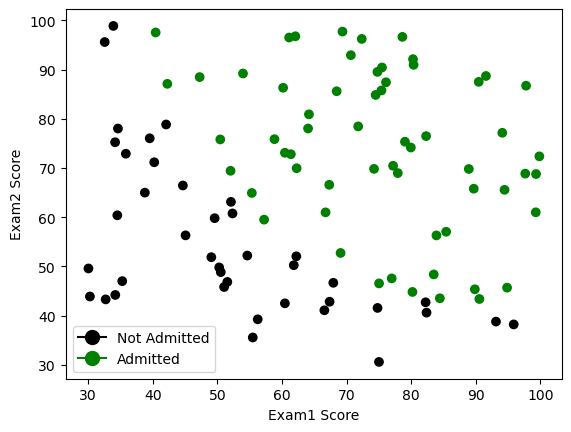

In [10]:
pred=[]
pred_logits=[]
features_norm = features_norm.cpu()
labels_orig_i = labels_orig_i.cpu()

for i, (features_norm, labels_orig_i) in enumerate(data_loader):

    with torch.no_grad():
        #obtain predictions from trained model_LR
        predictions = model.forward(features_norm)

    # pred_logits = np.append(pred_logits,predictions.detach().numpy())
    pred_logits = np.append(pred_logits, predictions.cpu().detach().numpy())

pred = [1 if entry >= 0 else 0 for entry in pred_logits]
pred_np = np.array(pred)

## Plot the results ##

# Define colors and labels based on pred values
colors = np.where(pred_np == 0, 'black', 'green')
labels = np.where(pred_np == 0, 'Not Admitted', 'Admitted')

# Scatter plot with different colors based on pred
plt.scatter(features_df[:,0], features_df[:,1], c=colors,marker='o')

# Add labels and legend
plt.xlabel('Exam1 Score')
plt.ylabel('Exam2 Score')

legend_labels = ['Not Admitted', 'Admitted']
legend_markers = [plt.Line2D([0], [0], marker='o', color=color, label=label, markersize=10) for color, label in zip(['black', 'green'], legend_labels)]

# Add the legend
plt.legend(handles=legend_markers)

plt.show()

# Use the Model to Predict Classification for New Data

In [26]:
# New data
new_features_np = np.array([[50., 50.],[35.,99.],[94.,38.],[80.,80.]])
new_features_torch = torch.from_numpy(new_features_np).float()

# Normalize new data
new_features_norm=(new_features_torch-avg_f)/std_f

# Move new data to GPU if it is available
new_features_norm = new_features_norm.to(compute_device)

# Create a data loader
new_data_loader = torch.utils.data.DataLoader(new_features_norm, batch_size=4, shuffle=False)

new_feature_pred=[]
new_pred_logits=[]

def model_LR(new_features_norm):
    # Forward pass
    predictions = model.forward(new_features_norm)
    return predictions

for new_features_norm in new_data_loader:

    with torch.no_grad():
            new_predictions = model_LR(new_features_norm)

    new_pred_logits = np.append(new_pred_logits,new_predictions.cpu().detach().numpy())



# new_feature_pred = [1 if entry >= 0 else 0 for entry in new_pred_logits]
new_feature_pred = ["Admitted" if entry >= 0 else "Not Admitted" for entry in new_pred_logits]

# Display classifications
for i in range(len(new_feature_pred)):
    print(f'Student {i + 1} scores: {new_features_np[i]}')
    print(f'Admission decision: {new_feature_pred[i]}\n')

Student 1 scores: [50. 50.]
Admission decision: Not Admitted

Student 2 scores: [35. 99.]
Admission decision: Not Admitted

Student 3 scores: [94. 38.]
Admission decision: Not Admitted

Student 4 scores: [80. 80.]
Admission decision: Admitted



# Define the Second Neural Network

This neural network will take a $28\times28$ grayscale image as input, and it will have 2 hidden layers of size 512 and a single output layer of size 10.  All hidden layers use the `ReLU` activation function.

In [27]:
class NeuralNetModel1(nn.Module):
    def __init__(self):
        super(NeuralNetModel1, self).__init__()

        # Input layer
        self.input_layer = nn.Flatten()

        # Hidden layer 1
        self.linear_layer1 = nn.Linear(in_features=28*28, out_features=512)

        # Hidden layer 2
        self.linear_layer2 = nn.Linear(in_features=512, out_features=512)

        # Output layer
        self.output_layer = nn.Linear(in_features=512, out_features=10)

        # Activation function used for all hidden layers
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.linear_layer1(x)
        x = self.relu(x)
        x = self.linear_layer2(x)
        x = self.relu(x)
        logits = self.output_layer(x)
        return logits

# Test
sample_input = torch.randn(5, 28, 28)
print('input size:', sample_input.size())

model1 = NeuralNetModel1()
with torch.no_grad():
    output = model1(sample_input)
print('output size:', output.size())

input size: torch.Size([5, 28, 28])
output size: torch.Size([5, 10])


Expected output:

input size: torch.Size([5, 28, 28])\
output size: torch.Size([5, 10])

# Load Dataset

The FashionMNIST dataset consists of 60,000 examples for training and 10,000 examples for testing, and each example is a $28\times 28$ grayscale image associated with one of the following classes:

T-shirt/top<br>
Trouser<br>
Pullover<br>
Dress<br>
Coat<br>
Sandal<br>
Shirt<br>
Sneaker<br>
Bag<br>
Ankle boot

In [28]:
# Collate function to move data to GPU
def collate_fn(batch):
    if torch.cuda.is_available():
        inputs, targets = zip(*batch)
        inputs = torch.stack(inputs).to(compute_device)
        targets = torch.tensor(targets).to(compute_device)
        return inputs, targets

training_data = datasets.FashionMNIST(
    root="data",
    train=True, # Use training data to train
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # Do not use test data to train
    download=True,
    transform=ToTensor()
)

batch_size = 64

# Create train_loader and test_loader using collate_fn to move data to GPU if available
train_loader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print('Training data size:', len(training_data))
print('Testing data size:', len(test_data))
print('No of Training Batches:', len(train_loader))
print('No of Test Batches:', len(test_loader))

count = 0
for batch in train_loader:
    X, y = batch
    print('X size:', X.size())
    print('y size:', y.size())
    count += 1
    if count > 0:
        break

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.45MB/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.35MB/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw

Training data size: 60000
Testing data size: 10000
No of Training Batches: 938
No of Test Batches: 157
X size: torch.Size([64, 1, 28, 28])
y size: torch.Size([64])


Expected output:

Training data size: 60000<br>
Testing data size: 10000<br>
No of Training Batches: 938<br>
No of Test Batches: 157<br>
X size: torch.Size([64, 1, 28, 28])<br>
y size: torch.Size([64])<br>

# Define Loss Function and Optimizer

In [31]:
learning_rate = 1e-3

nn_model = NeuralNetModel1()
nn_model = nn_model.to(compute_device)

loss_fn = nn.CrossEntropyLoss()
optimizer_sgd = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)

# Implement Training and Testing Functions

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    for i, (X, y) in enumerate(dataloader):
        # Compute prediction with forward pass
        outputs = model.forward(X)

        # calculate loss
        loss = loss_fn(outputs, y)

        # Backpropagation
        # zero gradients to start fresh for current epoch
        optimizer.zero_grad()

        # calculate gradients
        loss.backward()

        # update parameters
        optimizer.step()

        if verbose and i % 100 == 0:
            loss = loss.item()
            current_step = i * len(X)
            print(f"loss: {loss:>7f}  [{current_step:>5d}/{len(dataloader.dataset):>5d}]")

In [40]:
@torch.no_grad() # Do not want to update gradients when operating on testing data
def test_loop(dataloader, model, loss_fn):
    test_loss, correct = 0, 0
    # test_pred_logits = []


    for X, y in dataloader:
        # Compute prediction with forward pass
        test_pred_logits = model.forward(X)

        # Compute batch loss
        test_loss = loss_fn(test_pred_logits, y)

        # convert logits to predictions
        test_pred = test_pred_logits.argmax(1)  # finds the index of the highest value logit
                                                # among the 10 classes output by the model
        test_pred_np = test_pred.cpu().detach().numpy()
        y_np = y.cpu().detach().numpy()

        correct += np.sum(np.where(test_pred_np == y_np, 1, 0)) / len(X)

    # Calculate total test loss
    test_loss /= len(dataloader)

    # Calculate the prediction accuracy
    test_acc = correct / len(dataloader)

    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

# Train and Test the Model

In [41]:
# Instantiate the model
model1 = NeuralNetModel1().to(compute_device)

# Define the loss function and optimizer for new instance of model
loss_fn_model1 = nn.CrossEntropyLoss()
optimizer_sgd_model1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)


epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Train the model
    train_loop(train_loader, model1, loss_fn_model1, optimizer_sgd_model1)

    # Test the model
    test_loop(test_loader, model1, loss_fn_model1)

print("Done!")

Epoch 1
-------------------------------
loss: 2.305735  [    0/60000]
loss: 2.292802  [ 6400/60000]
loss: 2.270022  [12800/60000]
loss: 2.266188  [19200/60000]
loss: 2.248226  [25600/60000]
loss: 2.211339  [32000/60000]
loss: 2.232925  [38400/60000]
loss: 2.187452  [44800/60000]
loss: 2.187515  [51200/60000]
loss: 2.153565  [57600/60000]
Test Error: 
 Accuracy: 32.4%, Avg loss: 0.013989 

Epoch 2
-------------------------------
loss: 2.161796  [    0/60000]
loss: 2.152387  [ 6400/60000]
loss: 2.090951  [12800/60000]
loss: 2.115045  [19200/60000]
loss: 2.065664  [25600/60000]
loss: 1.998337  [32000/60000]
loss: 2.037060  [38400/60000]
loss: 1.947046  [44800/60000]
loss: 1.950698  [51200/60000]
loss: 1.888266  [57600/60000]
Test Error: 
 Accuracy: 54.9%, Avg loss: 0.012451 

Epoch 3
-------------------------------
loss: 1.914299  [    0/60000]
loss: 1.889904  [ 6400/60000]
loss: 1.768770  [12800/60000]
loss: 1.822092  [19200/60000]
loss: 1.713105  [25600/60000]
loss: 1.658922  [32000/600

# Train and Test the Model Using ADAM Optimization Algorithm

In [42]:
# Re-instantiate the model
model1 = NeuralNetModel1().to(compute_device)
loss_fn_model1 = nn.CrossEntropyLoss()

# Specify ADAM optimization algorithm
optimizer_adam = torch.optim.Adam(model1.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    # Train the model
    train_loop(train_loader, model1, loss_fn_model1, optimizer_adam)

    # Test the model
    test_loop(test_loader, model1, loss_fn_model1)

print("Done!")

Epoch 1
-------------------------------
loss: 2.305407  [    0/60000]
loss: 0.553873  [ 6400/60000]
loss: 0.378855  [12800/60000]
loss: 0.503486  [19200/60000]
loss: 0.462381  [25600/60000]
loss: 0.454920  [32000/60000]
loss: 0.377389  [38400/60000]
loss: 0.541003  [44800/60000]
loss: 0.481604  [51200/60000]
loss: 0.505461  [57600/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.001534 

Epoch 2
-------------------------------
loss: 0.266995  [    0/60000]
loss: 0.346436  [ 6400/60000]
loss: 0.290612  [12800/60000]
loss: 0.385883  [19200/60000]
loss: 0.460996  [25600/60000]
loss: 0.352671  [32000/60000]
loss: 0.302247  [38400/60000]
loss: 0.469326  [44800/60000]
loss: 0.444516  [51200/60000]
loss: 0.450809  [57600/60000]
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.001346 

Epoch 3
-------------------------------
loss: 0.241854  [    0/60000]
loss: 0.300877  [ 6400/60000]
loss: 0.233242  [12800/60000]
loss: 0.343159  [19200/60000]
loss: 0.396990  [25600/60000]
loss: 0.355681  [32000/600

It can be seen that using the ADAM optimization algorithm facilitates faster convergence when training the model, as well as higher accuracy after the 10 training epochs used in this example.